# Sign Language recognition on the MNIST Dataset 

In this project, we decided to explore computer vision algorithms in order to label hand signs that represent a letter of the alphabet in sign language. One first step in the project is to use the [MNIST dataset](https://github.com/metsey99/MNIST-Sign-Language-Dataset) for sign language recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Save path
save_path = '/content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/FINAUX/saves/'

In [3]:
# Libraries
from sklearn.metrics import accuracy_score
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import string
import tensorflow as tf

In [4]:
# Enable training or not
training = False

## Download the data, preprocess it and do data augmentation

In [5]:
# Clone the data repository
!git clone https://github.com/metsey99/MNIST-Sign-Language-Dataset

Cloning into 'MNIST-Sign-Language-Dataset'...
remote: Enumerating objects: 34703, done.
remote: Total 34703 (delta 0), reused 0 (delta 0), pack-reused 34703
Receiving objects: 100% (34703/34703), 54.66 MiB | 49.48 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (34629/34629), done.


In order to load the images as well as their labels and feed them to our neural network we use the ImageDataGenerator from Keras.

We apply some preprocessing, such as rescaling the pixels. 

Then, we apply some data augmentation methods:


*   Shifting
*   Zooming
*   Small rotation

Flipping the image is impossible since it could completely change the meaning of the sign. Hence we have to pay attention to the data augmentation methods we use.



In [6]:
# Create the data loader

## Build the generators

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    rotation_range=10,
    rescale=1. / 255)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

## Load the data
training_generator = train_datagen.flow_from_directory(
    '/content/MNIST-Sign-Language-Dataset/train', 
    target_size=(28,28),
    batch_size=128,
    class_mode='categorical',
    color_mode = 'grayscale',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    '/content/MNIST-Sign-Language-Dataset/test',
    target_size=(28,28),
    batch_size=128,
    class_mode='categorical',
    color_mode = 'grayscale',
    shuffle=False
)

Found 27455 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


We have 27455 images in the training dataset, 7172 in the testing set. The labels are numbers between 0 and 25 which represents the letter in the alphabet. Letters 'j' and 'z' are not represented here since their sign in the sign language are not compatible with static images.

Here, we do a quick mapping from the number to the letter in order to easily visualize the results.

In [7]:
# Build mappings
alphabet_jayz = [x for x in string.ascii_lowercase if x != 'j' and x != 'z' ]
alphabet_mapping = { letter : letter_idx for letter_idx, letter in enumerate(string.ascii_lowercase) }
alphabet_mapping_reverse = { letter_idx : letter for letter_idx, letter in enumerate(string.ascii_lowercase) }
alphabet_jayz_mapping = { letter : letter_idx for letter_idx, letter in enumerate(alphabet_jayz) }
alphabet_jayz_mapping_reverse = { letter_idx : letter for letter_idx, letter in enumerate(alphabet_jayz) }

In [10]:
# Build and save the reverse dictionnary for outputs
class_indices_rev = { k : v.upper() for k,v in alphabet_jayz_mapping_reverse.items() }
with open(save_path + 'class_indices_rev_mnist_dataset.h5', 'wb') as f:
  pickle.dump(class_indices_rev, f)

Let's visualize the distribution of the letters in the training dataset :

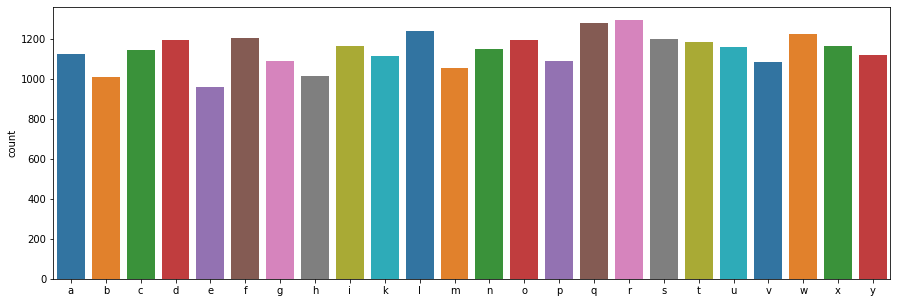

In [ ]:
# Vizualize the distribution of classes
plt.figure(figsize = (15,5)) 
sns.countplot(x=training_generator.classes, palette='tab10')
plt.xticks(range(24),[alphabet_jayz_mapping_reverse[label] for label in np.unique(training_generator.classes)])
plt.show()

The dataset is well balanced. Now let's visualize one image per class :

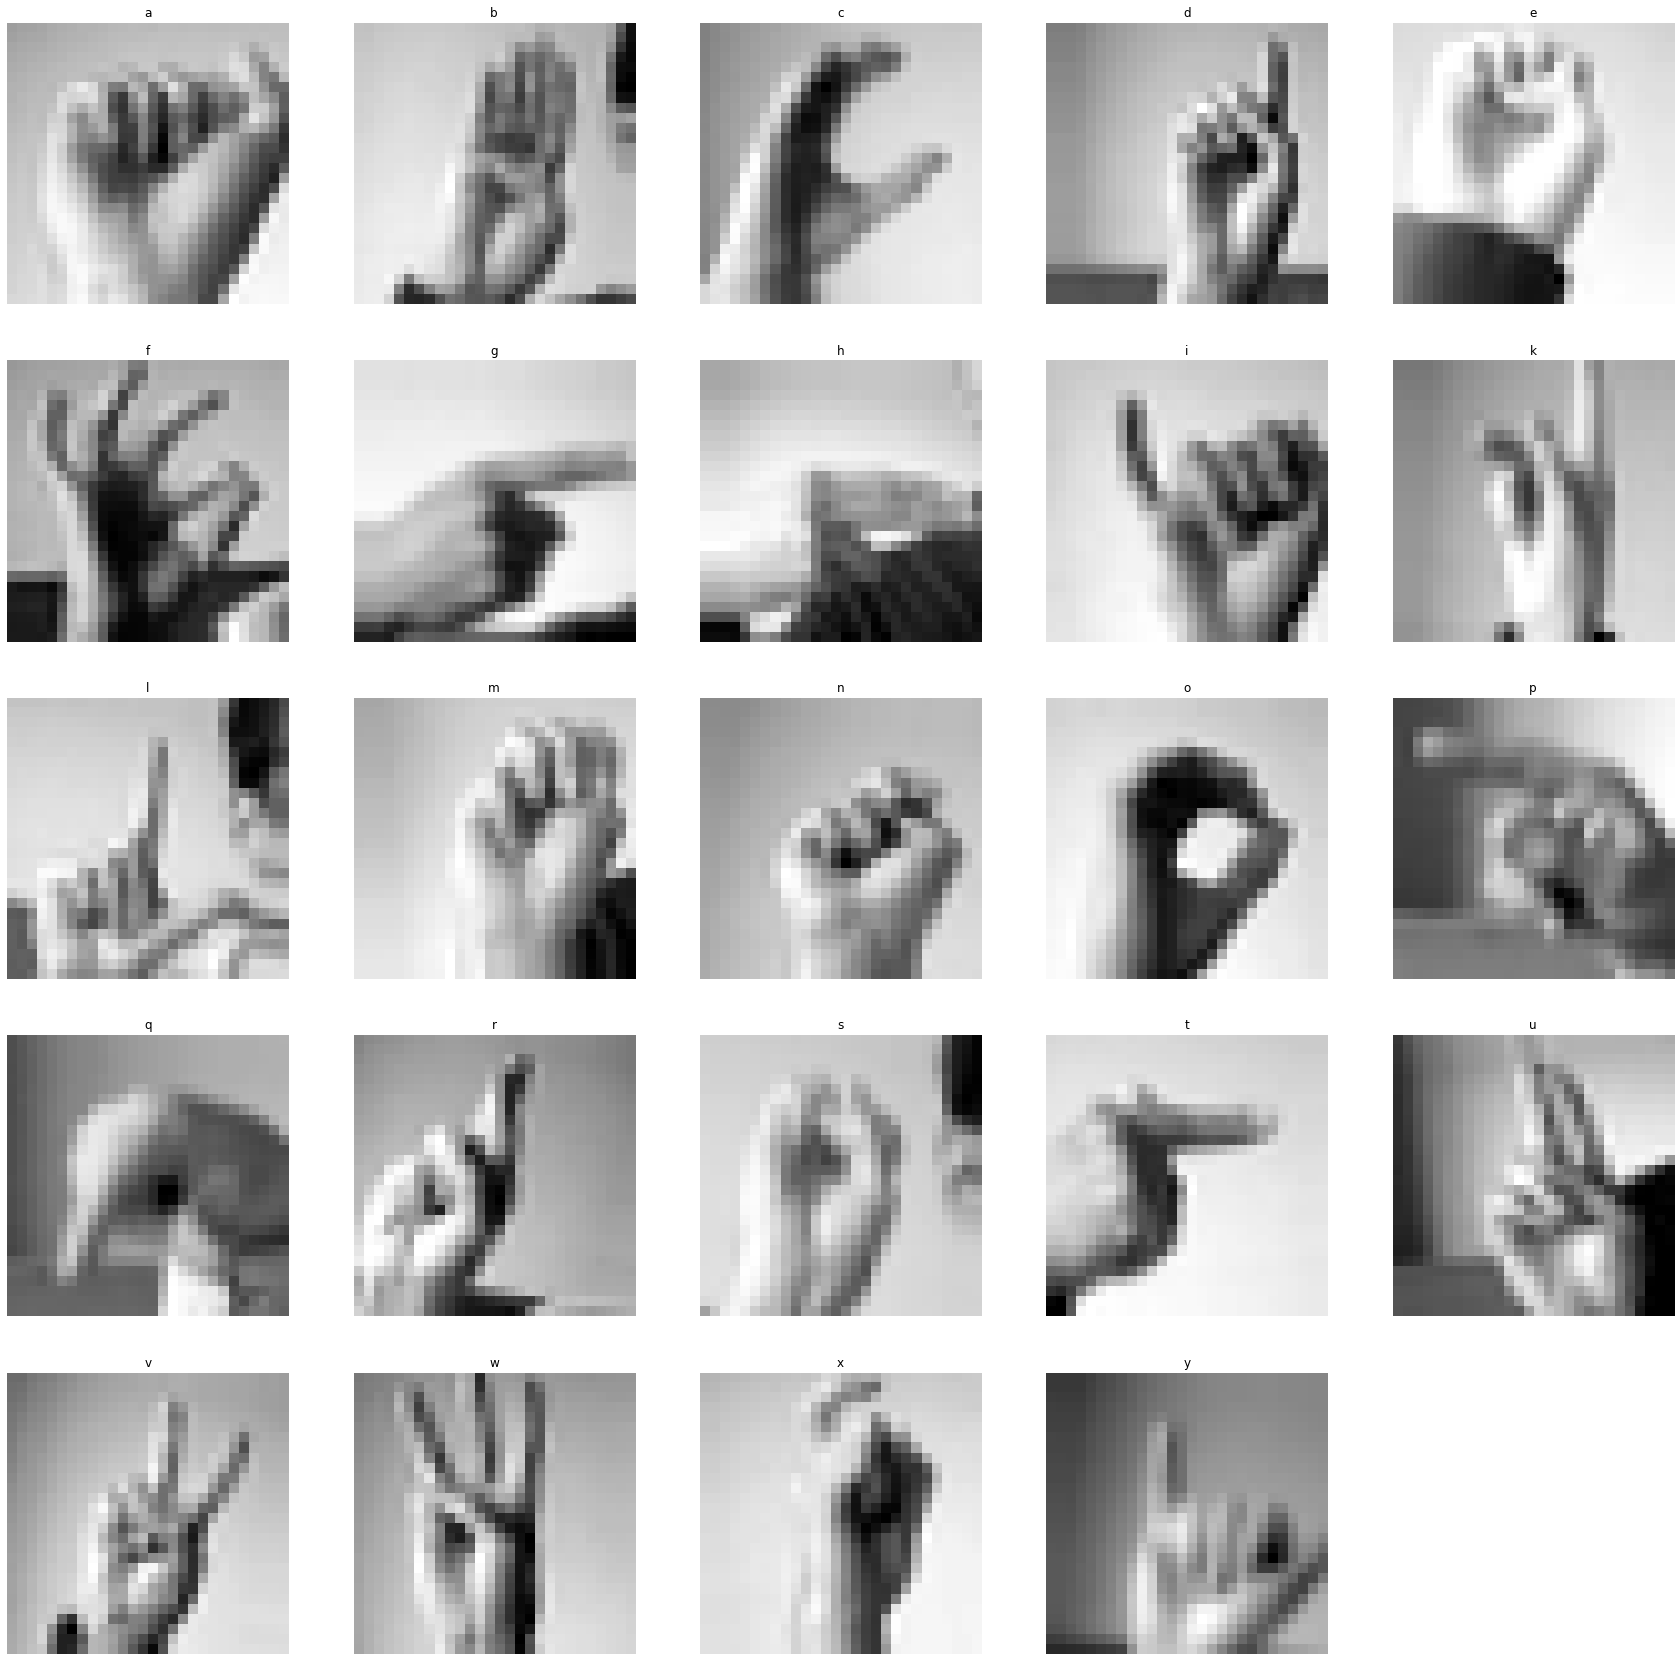

In [ ]:
# Visualize a few images
plt.figure(figsize=(30,30))
labels = sorted(list(alphabet_jayz_mapping.values()))
for i, label in enumerate(labels):
  plt.subplot(5, 5, i+1)
  # Select an image
  im = training_generator[0][0][np.argmax(training_generator[0][1], axis=1) == label][0]
  im = im.reshape((*im.shape[:-1]))
  plt.imshow(im, cmap='gray')
  plt.axis('off')
  plt.title(alphabet_jayz_mapping_reverse[label])
plt.show()

The images are 28*28 grayscale images. We can see that some signs are very close to each other (A,E,M,N,S for example). This will be challenging for our network. 

Plus, we notice that the hand always seems to be the same, as well as the background which is plain, without variability. This could pose problems of generalization to our network.


## Build and train the model

After few experimentations, we decided to build a convolutional neural network as follows :

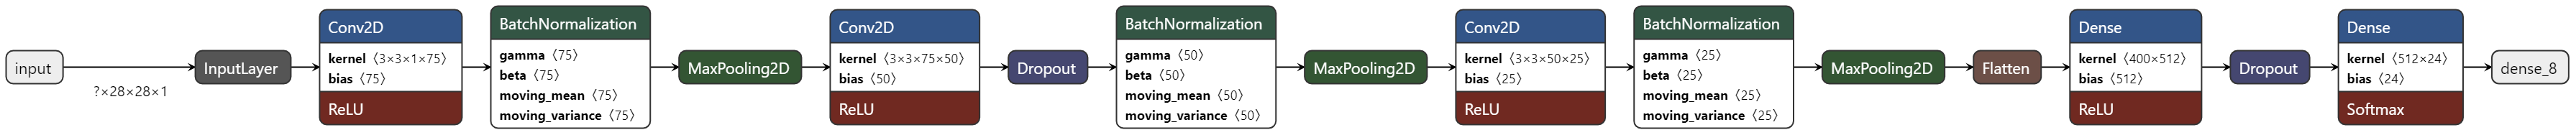

In [ ]:
# Build the model

## Custom learning rate scheduler
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=1e-5)

## Model
model = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(75, 3, strides=1, padding='same', activation='relu', input_shape=training_generator[0][0][0].shape),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(2, strides=2, padding='same'),
	tf.keras.layers.Conv2D(50, 3, strides=1, padding='same', activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(2 , strides=2 , padding='same'),
	tf.keras.layers.Conv2D(25, 3, strides=1 , padding='same' , activation='relu'),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(2 , strides=2 , padding='same'),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(512 , activation='relu'),
	tf.keras.layers.Dropout(0.3),
	tf.keras.layers.Dense(training_generator[0][1].shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 75)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 50)      

We choose to use a ReduceLROnPlateau for the learning rate, an adam optimizer. The loss to be optimized for this multi-class classification problem is the categorical cross entropy loss.

In [ ]:
if training:
  # Checkpoint
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path + 'model_mnist_dataset.h5', save_weights_only=False,
                                                monitor='val_accuracy',  verbose=1, save_best_only=True, mode='max')
  # Train the model
  history = model.fit(training_generator, epochs=25, validation_data=validation_generator, callbacks=[lr_callback, checkpoint])
  # Save the history
  with open(save_path + 'model_mnist_dataset_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
  history = history.history
else:
  # Load the model from saves
  model = tf.keras.models.load_model(save_path + 'model_mnist_dataset.h5')
  with open(save_path + 'model_mnist_dataset_history.pkl', 'rb') as f:
    history = pickle.load(f)

Epoch 1/25
215/215 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.7273
Epoch 1: val_accuracy improved from -inf to 0.10513, saving model to /content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/FINAUX/saves/model_mnist_dataset.h5
215/215 [==============================] - 17s 78ms/step - loss: 0.8705 - accuracy: 0.7273 - val_loss: 4.4772 - val_accuracy: 0.1051 - lr: 0.0010
Epoch 2/25
215/215 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9512
Epoch 2: val_accuracy improved from 0.10513 to 0.59663, saving model to /content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/FINAUX/saves/model_mnist_dataset.h5
215/215 [==============================] - 19s 89ms/step - loss: 0.1552 - accuracy: 0.9512 - val_loss: 1.3960 - val_accuracy: 0.5966 - lr: 0.0010
Epoch 3/25
215/215 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9763
Epoch 3: val_accuracy improved from 0.59663 to 0.80075, saving model to /content/drive/MyDriv

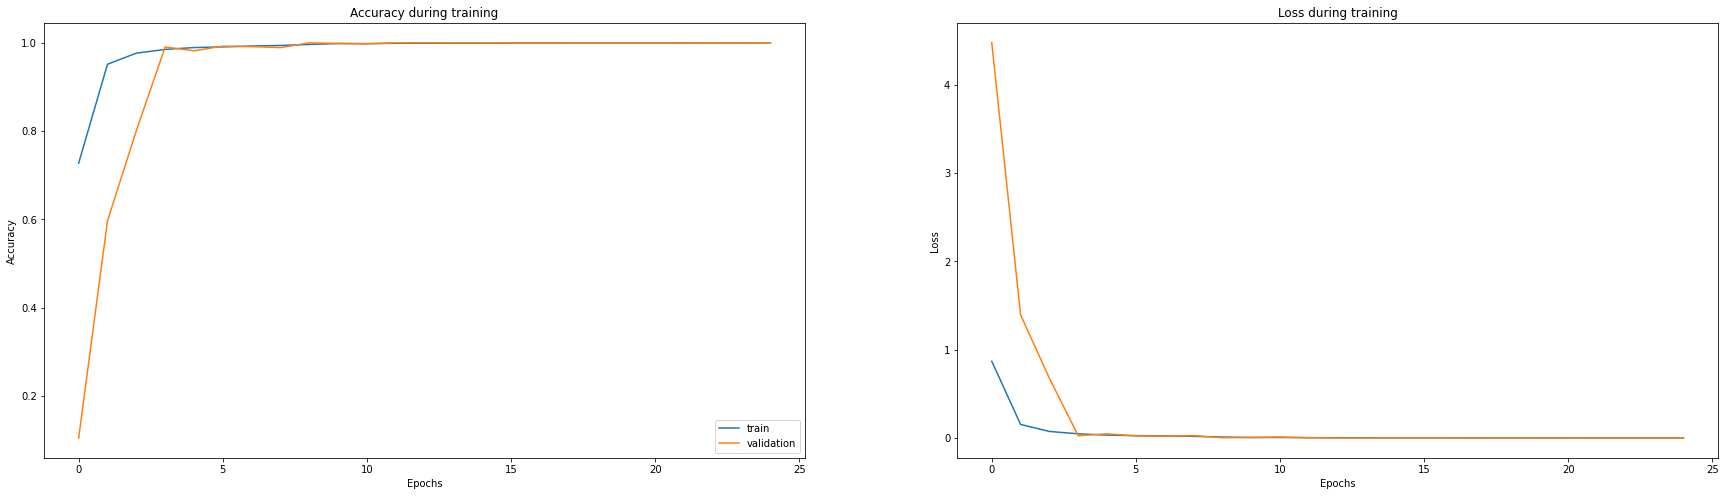

In [ ]:
# Plot the learning curve
plt.figure(figsize=(30,8), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy during training')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.show()

### Results

In [ ]:
# Evaluate the model on the test dataset
result = model.evaluate(validation_generator)

57/57 [==============================] - 2s 30ms/step - loss: 0.0015 - accuracy: 0.9999


Our results on the test set are very good. Almost 100% on the test set.

Intuitevely, this is quite surprising given the task and the images we observed before. One intuition is that the images from the test set are to close to the one from the train set, or that they are too 'perfect' (always well centered, with a plain background, ...), which is bad for generalization. That's why we decided to test our model on our own home-made dataset (see more details in the noteebook **New data - Data preparation**).



## Experiments on the new dataset

Because our model works very well on the MNIST dataset, let's try it on our own dataset. 

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/new_data_filtered_splitted_v2.zip' 

Archive:  /content/drive/MyDrive/Colab Notebooks/AppliedDL/Project/new_data_filtered_splitted_v2.zip
   creating: data_new/
   creating: data_new/train/
   creating: data_new/train/L/
  inflating: data_new/train/L/Maryline_L_204.jpg  
  inflating: data_new/train/L/AAG_L_185.jpg  
  inflating: data_new/train/L/Chong_L_116.jpg  
  inflating: data_new/train/L/Célian Latex _L_100.jpg  
  inflating: data_new/train/L/Olivier_L_64.jpg  
  inflating: data_new/train/L/Maryline_L_108.jpg  
  inflating: data_new/train/L/Maryline_L_42.jpg  
  inflating: data_new/train/L/Célian_L_184.jpg  
  inflating: data_new/train/L/Charles_L_88.jpg  
  inflating: data_new/train/L/Maryline_L_216.jpg  
  inflating: data_new/train/L/AAG_L_190.jpg  
  inflating: data_new/train/L/Maryline_L_210.jpg  
  inflating: data_new/train/L/Guillaume_L_80.jpg  
  inflating: data_new/train/L/Charles_L_76.jpg  
  inflating: data_new/train/L/Ines_L_52.jpg  
  inflating: data_new/train/L/AAG_L_130.jpg  
  inflating: data_new/tra

Our image are high resolution images however we load them in 28*28 and in grayscale to feed the network. We apply the same preprocessing as before.

In [ ]:
# Create the data loader

## Build a generator
new_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

## Load the data
new_generator = train_datagen.flow_from_directory(
    'data_new/train', 
    target_size=(28,28),
    batch_size=128,
    class_mode='categorical',
    color_mode = 'grayscale',
    shuffle=True
)

Found 3484 images belonging to 24 classes.


In [ ]:
# Evaluate on this data
y_pred_new = model.evaluate(new_generator)

28/28 [==============================] - 16s 571ms/step - loss: 12.1425 - accuracy: 0.0675


The results are very bad, almost random prediction... Let's explore the prediction on the first batch more into details:

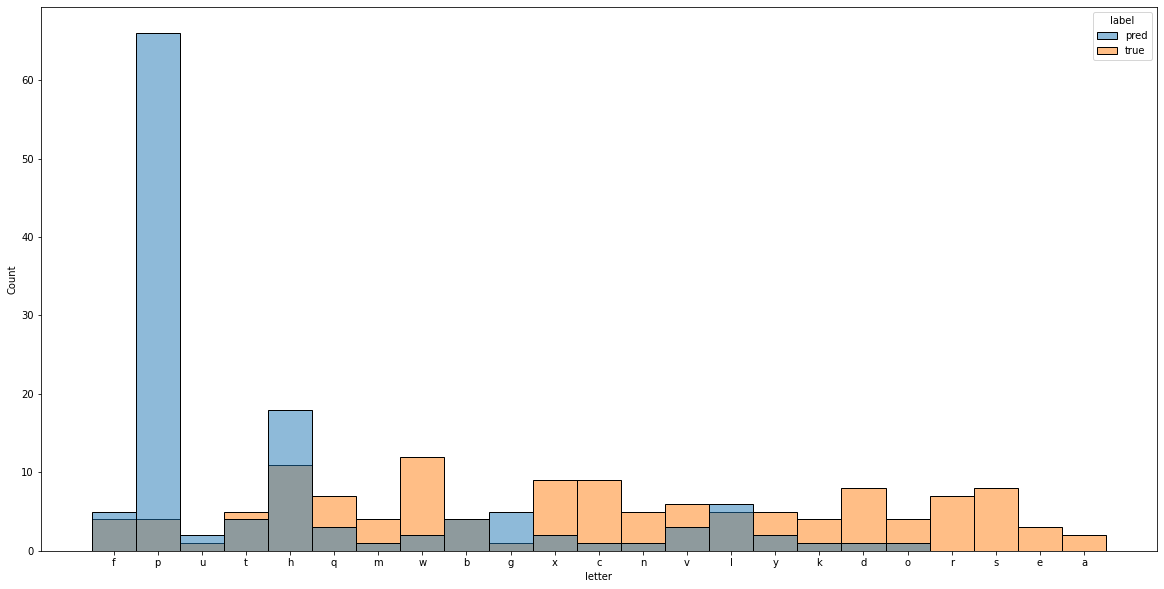

In [ ]:
# Get the letters from the prediction
pred = [alphabet_jayz_mapping_reverse[x] for x in np.argmax(model(new_generator[0][0]), axis=1)]
true = [alphabet_jayz_mapping_reverse[x] for x in np.argmax(new_generator[0][1], axis=1)]
pred_df = pd.DataFrame({ 'letter' : pred + true, 'label' : ['pred'] * len(pred) + ['true'] * len(true) })

# Plot the histograms
plt.figure(figsize=(20,10))
sns.histplot(data=pred_df, x='letter', hue='label')
plt.show()

The letter 'p' seems to be problematic.  First, let's reverse engineer our model to understand how it does its prediction. In a second step we will try to create a more robust model (see notebooks **New data - First bad model** and **New data - Finetuning of pretrained**) and therefore more applicable to real-world data or even live prediction (see our **github** for the Yolo algorithm). 

## Understanding the prediction and reverse engineering on MNIST dataset

### Confusion matrix

In [ ]:
# Make a prediction
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=-1)
y_true = validation_generator.classes
accuracy_score(y_true,y_pred)

0.9998605688789738

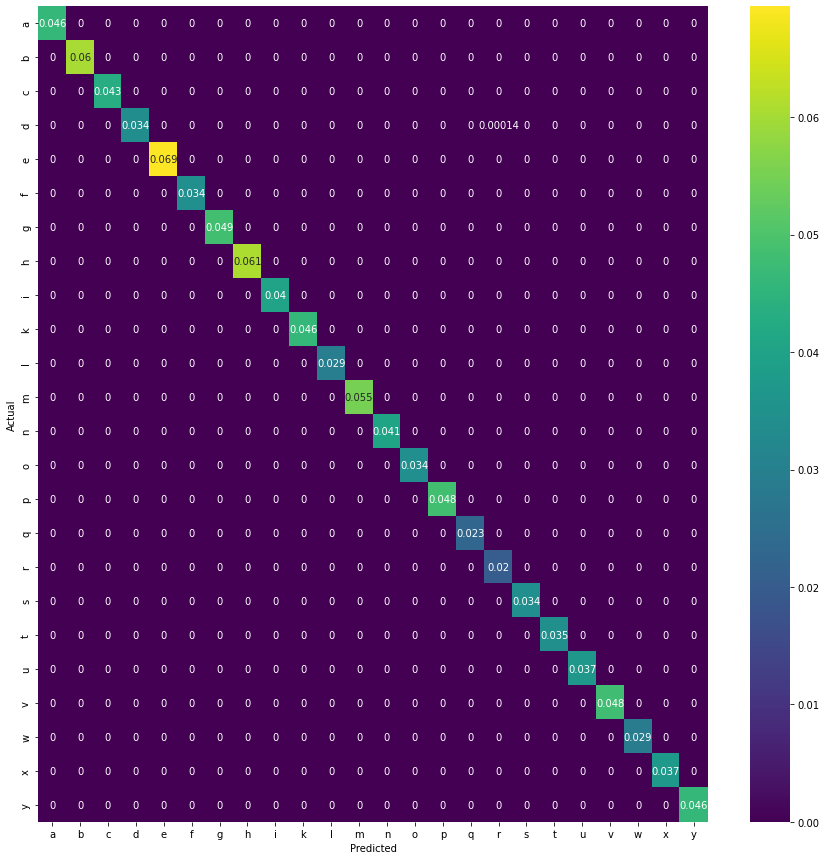

In [ ]:
# Make the confusion matrix

## Build a dataframe
data = {
  'Actual labels': y_true,
  'Predicted labels': y_pred
}
axis_labels= alphabet_jayz_mapping_reverse.values()
df = pd.DataFrame(data, columns=['Actual labels','Predicted labels'])

## Compute the confusion matrix
confusion_matrix = pd.crosstab(df['Actual labels'], df['Predicted labels'], rownames=['Actual'], colnames=['Predicted'], normalize='all')

## Plot the heapmap
plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, cmap='viridis')
plt.show()

As expected, the resulting confusion matrix is very good ! We see that most of the images are classified in the good classes and there very few missclassifications (hence the 99.99% accuracy).

### GradCam heatmaps

Because (almost) all the images are well classified, let's look at where the network is "looking" to make its prediction, in order to understand if these predictions make sense or if the network relies on subsidiary data (such as the background).

In [ ]:
# Download vizgradcam
!git clone https://github.com/gkeechin/vizgradcam
!cp vizgradcam/gradcam.py .

Cloning into 'vizgradcam'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 32), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (67/67), done.


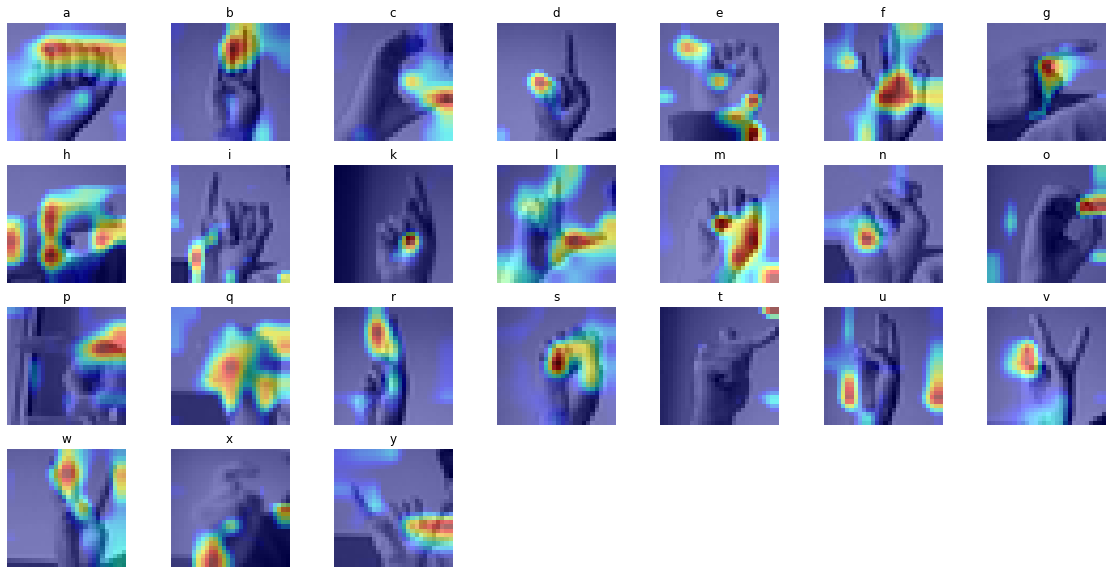

In [ ]:
# Visualize a few images

from gradcam import VizGradCAM

plt.figure(figsize=(20,10))
for i, label in enumerate(labels):
  plt.subplot(4, 7, i+1)
  # Select an image
  idx = np.argmax(validation_generator.classes == label)
  filename = '/content/MNIST-Sign-Language-Dataset/test/' + validation_generator.filenames[idx]
  im = np.array(cv2.imread(filename, cv2.IMREAD_GRAYSCALE)) / 255
  # Calculer Grad-CAM
  interpolant = 0.5
  cvt_heatmap = VizGradCAM(model, im, plot_results=False, interpolant=interpolant)
  im = np.repeat(np.expand_dims(im, axis=-1), 3, axis=-1)
  plt.imshow(np.uint8(im * 255 * interpolant + cvt_heatmap * (1 - interpolant)))
  plt.axis('off')
  plt.title(alphabet_jayz_mapping_reverse[label])
plt.show()

We can see that the model often focuses on the thumb to conclude on the sign to predict. All in all, the model definitely learnt something.